<a href="https://colab.research.google.com/github/Rtengmiami/TimeSeries/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
from prophet import Prophet
import seaborn as sns
import numpy as np
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [33]:
from matplotlib.pyplot import figure

figure(figsize=(18, 6))


<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

### Data Processing


In [34]:
df= pd.read_csv('/content/drive/MyDrive/NTUST/111-1/資料探勘 mon/期末報告/bitcoin_data.csv')
# df['Timestamp']=pd.to_datetime(df['Timestamp'], unit='s')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#Data processing
df['Timestamp']=pd.to_datetime(df['Timestamp'], unit='s')
df.index = df.Timestamp
df = df. resample('W').mean()
df_Prophet_addreg = df.copy()
df = df.reset_index()
df = df[['Timestamp','Weighted_Price']]
df.rename(columns = {'Timestamp':'ds',"Weighted_Price":"y"},inplace = True)
df.head()


,ds,y
0,2012-01-01,4.615202
1,2012-01-08,6.012609
2,2012-01-15,6.846930
3,2012-01-22,6.332164
4,2012-01-29,6.125839


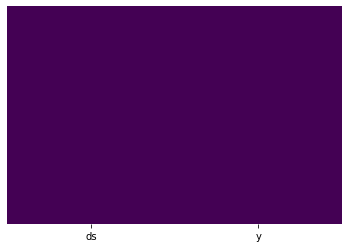

In [36]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [37]:
day_split = '2020-01-01'
train_data = df[df['ds']<=day_split] 
test_data = df[df['ds']>day_split] 
c=len(test_data)

###Model_First

In [38]:
m = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True)
m.fit(train_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/jjjxccvh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/1vq8h2cl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52875', 'data', 'file=/tmp/tmp43ug163o/jjjxccvh.json', 'init=/tmp/tmp43ug163o/1vq8h2cl.json', 'output', 'file=/tmp/tmp43ug163o/prophet_model9r36jred/prophet_model-20221226081555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:15:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:15:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
future = m.make_future_dataframe(periods=c,freq ='W')
future.tail()

,ds
479,2021-03-07
480,2021-03-14
481,2021-03-21
482,2021-03-28
483,2021-04-04


In [40]:
# forecast
forecast= m.predict(future)
forecast[['ds',"yhat","yhat_upper","yhat_lower"]].head()


,ds,yhat,yhat_upper,yhat_lower
0,2012-01-01,482.610451,4141.869124,-3238.345593
1,2012-01-08,428.562911,3771.239487,-3137.841734
2,2012-01-15,340.391194,4008.280644,-3042.871111
3,2012-01-22,170.426192,3636.528185,-3344.589128
4,2012-01-29,-81.355858,3571.109573,-3361.061572


###Visualize

In [41]:
test_data['yhat'] = forecast['yhat']
test_data.head()




<ipython-input-41-d5ee8d6f6168>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['yhat'] = forecast['yhat']


,ds,y,yhat
418,2020-01-05,7247.550026,9429.883242
419,2020-01-12,7958.877304,9390.939015
420,2020-01-19,8669.965061,9290.866342
421,2020-01-26,8504.334361,9097.357847
422,2020-02-02,9222.831691,8868.136482


[Text(0, 0.5, 'Weighted_Price'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Prophet_Bitcoin_begin at 2020')]

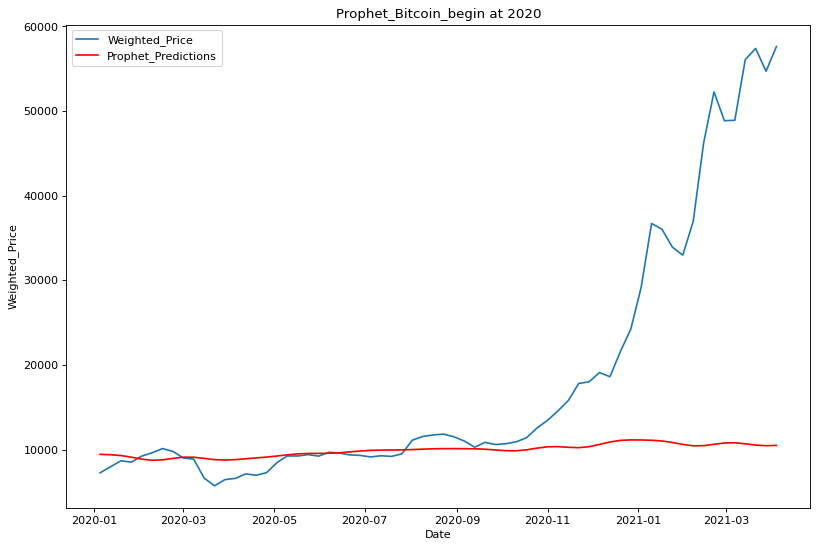

In [42]:
figure(figsize=(12, 8), dpi=80)
ax1 = sns.lineplot(data = test_data, x= 'ds',y ='y',label ='Weighted_Price')
sns.lineplot(data = test_data, x= 'ds',y ='yhat',color = 'r',label ='Prophet_Predictions')
ax1.set(xlabel = "Date", ylabel = "Weighted_Price",title ='Prophet_Bitcoin_begin at 2020')

In [43]:
prophet_rmse = rmse(test_data['y'], test_data["yhat"])
prophet_mse = prophet_rmse**2
mean_value = test_data['y'].mean()

print(f' RMSE:{prophet_rmse}\n MSE:{prophet_mse}\n Mean:{mean_value}')

 RMSE:16679.346682838932
 MSE:278200605.76633006
 Mean:18078.522318503947


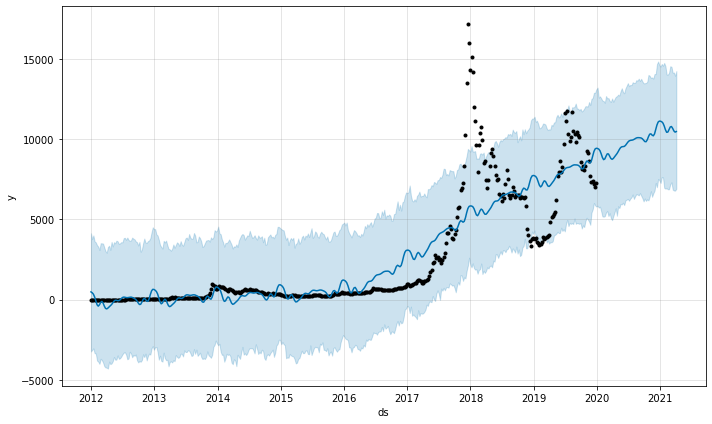

In [44]:
plt_1 = m.plot(forecast)

##Add exogenous_features

In [45]:
df_Prophet_addreg = df_Prophet_addreg.reset_index()


In [46]:
#Try to find the most suitable features
from itertools import combinations
lag_features = ["Open", "High", "Low", "Close",'Volume_(Currency)',"Volume_(BTC)"]
exogenous = []
for i in range (2,7):
  exogenous +=(list(combinations(lag_features,i)))

c = []
for j in exogenous:
  c.append(len(j))
exogenous

[('Open', 'High'),
 ('Open', 'Low'),
 ('Open', 'Close'),
 ('Open', 'Volume_(Currency)'),
 ('Open', 'Volume_(BTC)'),
 ('High', 'Low'),
 ('High', 'Close'),
 ('High', 'Volume_(Currency)'),
 ('High', 'Volume_(BTC)'),
 ('Low', 'Close'),
 ('Low', 'Volume_(Currency)'),
 ('Low', 'Volume_(BTC)'),
 ('Close', 'Volume_(Currency)'),
 ('Close', 'Volume_(BTC)'),
 ('Volume_(Currency)', 'Volume_(BTC)'),
 ('Open', 'High', 'Low'),
 ('Open', 'High', 'Close'),
 ('Open', 'High', 'Volume_(Currency)'),
 ('Open', 'High', 'Volume_(BTC)'),
 ('Open', 'Low', 'Close'),
 ('Open', 'Low', 'Volume_(Currency)'),
 ('Open', 'Low', 'Volume_(BTC)'),
 ('Open', 'Close', 'Volume_(Currency)'),
 ('Open', 'Close', 'Volume_(BTC)'),
 ('Open', 'Volume_(Currency)', 'Volume_(BTC)'),
 ('High', 'Low', 'Close'),
 ('High', 'Low', 'Volume_(Currency)'),
 ('High', 'Low', 'Volume_(BTC)'),
 ('High', 'Close', 'Volume_(Currency)'),
 ('High', 'Close', 'Volume_(BTC)'),
 ('High', 'Volume_(Currency)', 'Volume_(BTC)'),
 ('Low', 'Close', 'Volume_(Curr

In [ ]:
result_find = []
for i in range(0,len(exogenous)):
  i=i
  
  exogenous_fea = []
  for j in range(0,(c[i])):
    # print(exogenous[i][j])
    if j != (c[i]-1):
      
      exogenous_fea.append(exogenous[i][j])
    else:
      exogenous_fea.append(exogenous[i][j])
      j = j
      exogenous_features = []
      for k in range(0,j):
        exogenous_features.extend([f'{exogenous_fea[k]}_mean_lag3',f'{exogenous_fea[k]}_mean_lag7',f'{exogenous_fea[k]}_mean_lag30',
                                  f'{exogenous_fea[k]}_std_lag3',f'{exogenous_fea[k]}_std_lag7',f'{exogenous_fea[k]}_std_lag30'])
      # exogenous_features.extend(['month', 'week','day', 'day_of_week'])

      # lag_features = ["Open"]#, "High", "Low", "Close"]#'Volume_(Currency)"]#"Volume_(BTC)"
      window1 = 3
      window2 = 7
      window3 = 30

      df_rolled_3d = df_Prophet_addreg[exogenous_fea].rolling(window=window1, min_periods=0)
      df_rolled_7d = df_Prophet_addreg[exogenous_fea].rolling(window=window2, min_periods=0)
      df_rolled_30d = df_Prophet_addreg[exogenous_fea].rolling(window=window3, min_periods=0)

      df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
      df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
      df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()

      df_std_3d = df_rolled_3d.std().shift(1).reset_index()
      df_std_7d = df_rolled_7d.std().shift(1).reset_index()
      df_std_30d = df_rolled_30d.std().shift(1).reset_index()

      for feature in exogenous_fea:
          df_Prophet_addreg[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
          df_Prophet_addreg[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
          df_Prophet_addreg[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
          
          df_Prophet_addreg[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
          df_Prophet_addreg[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
          df_Prophet_addreg[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

      df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)

      # df_Prophet_addreg.set_index("Timestamp", drop=False, inplace=True)
      df_Prophet_addreg["month"] = df_Prophet_addreg.Timestamp.dt.month
      df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
      df_Prophet_addreg["day"] = df_Prophet_addreg.Timestamp.dt.day
      df_Prophet_addreg["day_of_week"] = df_Prophet_addreg.Timestamp.dt.dayofweek
      df_train = df_Prophet_addreg[df_Prophet_addreg.Timestamp < "2020"]
      df_valid = df_Prophet_addreg[df_Prophet_addreg.Timestamp >= "2020"]

      df_train = df_train.rename(columns = {'Timestamp':'ds',"Weighted_Price":"y"})
      df_valid = df_valid.rename(columns = {'Timestamp':'ds',"Weighted_Price":"y"})
      m2_fbp = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True,)
      for feature in exogenous_features:
        m2_fbp.add_regressor(feature)

      m2_fbp.fit(df_train[["ds", "y"] + exogenous_features])
      forecast2 = m2_fbp.predict(df_valid[["ds", "y"] + exogenous_features])
      # forecast2.head()
      test_data2 = df_valid[['ds','y']]
      test_data2 = test_data2.copy()
      yhat = forecast2.loc[:,"yhat"].values
      test_data2.insert(2,column ="yhat" ,value = yhat)
      test_data2 = test_data2.reset_index(drop = True)

      prophet_rmse2 = rmse(test_data2['y'], test_data2["yhat"])
      diff = round(((prophet_rmse2-prophet_rmse)/prophet_rmse),3)
      print("Difference of RMSE:"f'{i,":",diff}')
      result_find.append([i,":",diff])
            

In [48]:
for i in range(0,len(exogenous)):
  print(result_find[i],exogenous[i])

[0, ':', -0.766] ('Open', 'High')
[1, ':', -0.766] ('Open', 'Low')
[2, ':', -0.766] ('Open', 'Close')
[3, ':', -0.766] ('Open', 'Volume_(Currency)')
[4, ':', -0.766] ('Open', 'Volume_(BTC)')
[5, ':', -0.766] ('High', 'Low')
[6, ':', -0.766] ('High', 'Close')
[7, ':', -0.766] ('High', 'Volume_(Currency)')
[8, ':', -0.766] ('High', 'Volume_(BTC)')
[9, ':', -0.767] ('Low', 'Close')
[10, ':', -0.767] ('Low', 'Volume_(Currency)')
[11, ':', -0.767] ('Low', 'Volume_(BTC)')
[12, ':', -0.766] ('Close', 'Volume_(Currency)')
[13, ':', -0.766] ('Close', 'Volume_(BTC)')
[14, ':', -0.33] ('Volume_(Currency)', 'Volume_(BTC)')
[15, ':', -0.765] ('Open', 'High', 'Low')
[16, ':', -0.765] ('Open', 'High', 'Close')
[17, ':', -0.765] ('Open', 'High', 'Volume_(Currency)')
[18, ':', -0.765] ('Open', 'High', 'Volume_(BTC)')
[19, ':', -0.766] ('Open', 'Low', 'Close')
[20, ':', -0.766] ('Open', 'Low', 'Volume_(Currency)')
[21, ':', -0.766] ('Open', 'Low', 'Volume_(BTC)')
[22, ':', -0.766] ('Open', 'Close', 'Vol

In [49]:
#one features
lag_features = ["Open", "High", "Low", "Close",'Volume_(Currency)',"Volume_(BTC)",'month', 'week','day', 'day_of_week']
result_find_one = []
for i in lag_features:
  exogenous_features=[]
  exogenous_features.extend([f'{exogenous_fea[k]}_mean_lag3',f'{exogenous_fea[k]}_mean_lag7',f'{exogenous_fea[k]}_mean_lag30',
                            f'{exogenous_fea[k]}_std_lag3',f'{exogenous_fea[k]}_std_lag7',f'{exogenous_fea[k]}_std_lag30'])

  window1 = 3
  window2 = 7
  window3 = 30

  df_rolled_3d = df_Prophet_addreg[exogenous_features].rolling(window=window1, min_periods=0)
  df_rolled_7d = df_Prophet_addreg[exogenous_features].rolling(window=window2, min_periods=0)
  df_rolled_30d = df_Prophet_addreg[exogenous_features].rolling(window=window3, min_periods=0)

  df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
  df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
  df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()

  df_std_3d = df_rolled_3d.std().shift(1).reset_index()
  df_std_7d = df_rolled_7d.std().shift(1).reset_index()
  df_std_30d = df_rolled_30d.std().shift(1).reset_index()

  for feature in exogenous_features:
      df_Prophet_addreg[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
      df_Prophet_addreg[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
      df_Prophet_addreg[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
      
      df_Prophet_addreg[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
      df_Prophet_addreg[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
      df_Prophet_addreg[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

  df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)
  df_Prophet_addreg["month"] = df_Prophet_addreg.Timestamp.dt.month
  df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
  df_Prophet_addreg["day"] = df_Prophet_addreg.Timestamp.dt.day
  df_Prophet_addreg["day_of_week"] = df_Prophet_addreg.Timestamp.dt.dayofweek
  df_train = df_Prophet_addreg[df_Prophet_addreg.Timestamp < "2020"]
  df_valid = df_Prophet_addreg[df_Prophet_addreg.Timestamp >= "2020"]

  df_train = df_train.rename(columns = {'Timestamp':'ds',"Weighted_Price":"y"})
  df_valid = df_valid.rename(columns = {'Timestamp':'ds',"Weighted_Price":"y"})
  m2_fbp = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True,)
  for feature in exogenous_features:
    m2_fbp.add_regressor(feature)

  m2_fbp.fit(df_train[["ds", "y"] + exogenous_features])
  forecast2 = m2_fbp.predict(df_valid[["ds", "y"] + exogenous_features])
  test_data2 = df_valid[['ds','y']]
  test_data2 = test_data2.copy()
  yhat = forecast2.loc[:,"yhat"].values
  test_data2.insert(2,column ="yhat" ,value = yhat)
  test_data2 = test_data2.reset_index(drop = True)

  prophet_rmse2 = rmse(test_data2['y'], test_data2["yhat"])
  diff = round(((prophet_rmse2-prophet_rmse)/prophet_rmse),3)
  print("Difference of RMSE:"f'{i,":",diff}')
  result_find_one.append([i,":",diff])

<ipython-input-49-141136f9ad25>:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)
<ipython-input-49-141136f9ad25>:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/xzc_s_fo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/n6y328tk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30191', 'data', 'file=/tmp/tmp43ug163o/xzc_s_fo.json', 'init=/tmp/tmp43ug163o/n6y328tk.json', 'output', 'file=/tmp/tmp43ug163o/prophet_model3wd7ag1i/prophet_model-20221226081652.csv', 'method=optimiz

Difference of RMSE:('Open', ':', -0.33)


08:16:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-49-141136f9ad25>:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)
<ipython-input-49-141136f9ad25>:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/hh6if4cb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/u6pass9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35817', 'data', 'file=/tmp/tmp43ug163o/hh6if4cb.json', 'init=/tmp/tmp43ug163o/u6pass9j.json', 'output'

Difference of RMSE:('High', ':', -0.33)


08:16:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Difference of RMSE:('Low', ':', -0.33)


<ipython-input-49-141136f9ad25>:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)
<ipython-input-49-141136f9ad25>:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/bhc23gvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/heetupmt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68772', 'data', 'file=/tmp/tmp43ug163o/bhc23gvc.json', 'init=/tmp/tmp43ug163o/heetupmt.json', 'output', 'file=/tmp/tmp43ug163o/prophet_modelae8h4bgr/prophet_model-20221226081654.csv', 'method=optimiz

Difference of RMSE:('Close', ':', -0.33)


08:16:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-49-141136f9ad25>:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)
<ipython-input-49-141136f9ad25>:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/idflvs5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/sbdyur6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54787', 'data', 'file=/tmp/tmp43ug163o/idflvs5g.json', 'init=/tmp/tmp43ug163o/sbdyur6s.json', 'output'

Difference of RMSE:('Volume_(Currency)', ':', -0.33)


08:16:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-49-141136f9ad25>:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)
<ipython-input-49-141136f9ad25>:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/kqpp1trn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/toj93eap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76165', 'data', 'file=/tmp/tmp43ug163o/kqpp1trn.json', 'init=/tmp/tmp43ug163o/toj93eap.json', 'output'

Difference of RMSE:('Volume_(BTC)', ':', -0.33)


08:16:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-49-141136f9ad25>:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)
<ipython-input-49-141136f9ad25>:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/o9o6pmxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/ts0bhhd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57778', 'data', 'file=/tmp/tmp43ug163o/o9o6pmxz.json', 'init=/tmp/tmp43ug163o/ts0bhhd8.json', 'output'

Difference of RMSE:('month', ':', -0.33)


08:16:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-49-141136f9ad25>:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)
<ipython-input-49-141136f9ad25>:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/sw_k6s2e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/u8tp20yn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78181', 'data', 'file=/tmp/tmp43ug163o/sw_k6s2e.json', 'init=/tmp/tmp43ug163o/u8tp20yn.json', 'output'

Difference of RMSE:('week', ':', -0.33)


08:16:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-49-141136f9ad25>:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)
<ipython-input-49-141136f9ad25>:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/qy9iwl9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/0hq7untz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83967', 'data', 'file=/tmp/tmp43ug163o/qy9iwl9w.json', 'init=/tmp/tmp43ug163o/0hq7untz.json', 'output'

Difference of RMSE:('day', ':', -0.33)


08:16:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Difference of RMSE:('day_of_week', ':', -0.33)


In [50]:
result_find_one

[['Open', ':', -0.33],
 ['High', ':', -0.33],
 ['Low', ':', -0.33],
 ['Close', ':', -0.33],
 ['Volume_(Currency)', ':', -0.33],
 ['Volume_(BTC)', ':', -0.33],
 ['month', ':', -0.33],
 ['week', ':', -0.33],
 ['day', ':', -0.33],
 ['day_of_week', ':', -0.33]]

In [51]:
exogenous_features = ['Open_mean_lag3','Open_mean_lag7', 'Open_mean_lag30', 
                      'Open_std_lag3', 'Open_std_lag7','Open_std_lag30', 
                      'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
                      'High_std_lag3', 'High_std_lag7', 'High_std_lag30', 
                      'Low_mean_lag3','Low_mean_lag7', 'Low_mean_lag30',
                      'Low_std_lag3', 'Low_std_lag7','Low_std_lag30',
                      'Close_mean_lag3', 'Close_mean_lag7','Close_mean_lag30',
                      'Close_std_lag3', 'Close_std_lag7','Close_std_lag30',
                      'Volume_(BTC)_mean_lag3', 'Volume_(BTC)_mean_lag7',
                      'Volume_(BTC)_mean_lag30', 'Volume_(BTC)_std_lag3',
                      'Volume_(BTC)_std_lag7', 'Volume_(BTC)_std_lag30',
                      'Volume_(Currency)_mean_lag3', 'Volume_(Currency)_mean_lag7',
                      'Volume_(Currency)_mean_lag30', 'Volume_(Currency)_std_lag3',
                      'Volume_(Currency)_std_lag7', 'Volume_(Currency)_std_lag30', 
                      'month', 'week','day', 'day_of_week']  
                      
                      

In [52]:

lag_features = ["Open", "High", "Low", "Close"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df_Prophet_addreg[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df_Prophet_addreg[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df_Prophet_addreg[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()

df_std_3d = df_rolled_3d.std().shift(1).reset_index()
df_std_7d = df_rolled_7d.std().shift(1).reset_index()
df_std_30d = df_rolled_30d.std().shift(1).reset_index()

for feature in lag_features:
    df_Prophet_addreg[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df_Prophet_addreg[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df_Prophet_addreg[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df_Prophet_addreg[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df_Prophet_addreg[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df_Prophet_addreg[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)

# df_Prophet_addreg.set_index("Timestamp", drop=False, inplace=True)
df_Prophet_addreg["month"] = df_Prophet_addreg.Timestamp.dt.month
df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week
df_Prophet_addreg["day"] = df_Prophet_addreg.Timestamp.dt.day
df_Prophet_addreg["day_of_week"] = df_Prophet_addreg.Timestamp.dt.dayofweek
df_train = df_Prophet_addreg[df_Prophet_addreg.Timestamp < "2020"]
df_valid = df_Prophet_addreg[df_Prophet_addreg.Timestamp >= "2020"]

print('train shape :', df_train)#.shape)
print('validation shape :', df_valid)#.shape)

# df_Prophet_addreg.head()

train shape :      Timestamp         Open         High          Low        Close  \
0   2012-01-01     4.611429     4.621429     4.611429     4.621429   
1   2012-01-08     6.009286     6.017321     6.009286     6.017321   
2   2012-01-15     6.847168     6.850636     6.840867     6.845145   
3   2012-01-22     6.332981     6.335673     6.329327     6.332019   
4   2012-01-29     6.124828     6.126207     6.124052     6.125431   
..         ...          ...          ...          ...          ...   
413 2019-12-01  7355.340641  7360.972397  7349.737461  7355.226190   
414 2019-12-08  7379.551985  7383.959005  7375.480366  7379.547668   
415 2019-12-15  7232.351484  7235.530138  7228.947472  7232.250254   
416 2019-12-22  7037.059651  7041.362522  7033.078004  7037.068874   
417 2019-12-29  7295.606306  7299.060268  7292.198742  7295.650094   

     Volume_(BTC)  Volume_(Currency)  Weighted_Price  Open_mean_lag3  \
0       16.702840          75.871357        4.615202     4432.450268   
1

<ipython-input-52-38050d41525f>:27: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_Prophet_addreg.fillna(df_Prophet_addreg.mean(), inplace=True)
<ipython-input-52-38050d41525f>:31: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_Prophet_addreg["week"] = df_Prophet_addreg.Timestamp.dt.week


In [53]:
df_train = df_train.rename(columns = {'Timestamp':'ds',"Weighted_Price":"y"})
df_valid = df_valid.rename(columns = {'Timestamp':'ds',"Weighted_Price":"y"})

In [54]:
df_train

,ds,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),y,Open_mean_lag3,Open_mean_lag7,...,Volume_(Currency)_std_lag7_mean_lag30,Volume_(Currency)_std_lag7_std_lag3,Volume_(Currency)_std_lag7_std_lag7,Volume_(Currency)_std_lag7_std_lag30,Volume_(Currency)_std_lag30_mean_lag3,Volume_(Currency)_std_lag30_mean_lag7,Volume_(Currency)_std_lag30_mean_lag30,Volume_(Currency)_std_lag30_std_lag3,Volume_(Currency)_std_lag30_std_lag7,Volume_(Currency)_std_lag30_std_lag30
0,2012-01-01,4.611429,4.621429,4.611429,4.621429,16.702840,75.871357,4.615202,4432.450268,4211.507964,...,9132.168030,1820.177574,3165.824372,5264.186422,14811.363568,14361.978770,12771.083120,750.025931,1581.466296,4423.931259
1,2012-01-08,6.009286,6.017321,6.009286,6.017321,6.219625,35.272736,6.012609,4.611429,4.611429,...,11164.728597,1820.177574,3165.824372,5264.186422,15231.587087,15231.587087,15231.587087,750.025931,1581.466296,4423.931259
2,2012-01-15,6.847168,6.850636,6.840867,6.845145,2.308239,16.012406,6.846930,5.310357,5.310357,...,11164.728597,0.000000,0.000000,0.000000,15231.587087,15231.587087,15231.587087,0.000000,0.000000,0.000000
3,2012-01-22,6.332981,6.335673,6.329327,6.332019,7.036892,44.270967,6.332164,5.822627,5.822627,...,7452.721585,6429.384744,6429.384744,6429.384744,10163.960578,10163.960578,10163.960578,8777.386587,8777.386587,8777.386587
4,2012-01-29,6.124828,6.126207,6.124052,6.125431,3.389604,20.956109,6.125839,6.396478,5.950216,...,5597.180385,6428.850985,6428.850963,6428.850963,5096.950477,7630.609629,7630.609629,8776.852811,8776.852795,8776.852795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2019-12-01,7355.340641,7360.972397,7349.737461,7355.226190,6.692576,48613.539479,7355.472402,8502.049529,8499.792145,...,25968.944157,407.597784,4104.983658,9475.923384,32133.601312,32556.691237,29645.746329,39.497489,677.566592,8089.776511
414,2019-12-08,7379.551985,7383.959005,7375.480366,7379.547668,2.737669,20192.900208,7380.120877,7910.135600,8362.134842,...,26208.592063,459.159812,3598.242000,9294.609829,32093.663641,32292.175006,30258.323409,108.090949,410.654553,7507.021334
415,2019-12-15,7232.351484,7235.530138,7228.947472,7232.250254,2.563430,18620.481650,7232.664836,7491.278300,8261.090989,...,26471.281683,36.287659,2654.759743,9071.686306,31837.153608,32042.374327,30854.038341,393.335426,330.602188,6809.959618
416,2019-12-22,7037.059651,7041.362522,7033.078004,7037.068874,4.063312,28313.958170,7037.438063,7322.414703,8105.839297,...,26686.735336,824.530928,731.427431,8933.019590,31881.986590,32012.241334,31428.620439,449.975027,289.790394,6122.552032


In [55]:
m2_fbp = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True,)
for feature in exogenous_features:
   m2_fbp.add_regressor(feature)

m2_fbp.fit(df_train[["ds", "y"] + exogenous_features])
forecast2 = m2_fbp.predict(df_valid[["ds", "y"] + exogenous_features])
forecast2.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/buw77g_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp43ug163o/nt0m80k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52293', 'data', 'file=/tmp/tmp43ug163o/buw77g_j.json', 'init=/tmp/tmp43ug163o/nt0m80k6.json', 'output', 'file=/tmp/tmp43ug163o/prophet_model7f0nhnn1/prophet_model-20221226081700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:17:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:17:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Close_mean_lag3,Close_mean_lag3_lower,Close_mean_lag3_upper,Close_mean_lag30,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-05,4249.963875,5971.895033,7588.006377,4249.877578,4249.979134,2423.801976,2423.801976,2423.801976,-1014.453200,...,106.789959,106.789959,106.789959,-129.501329,-129.501329,-129.501329,0.0,0.0,0.0,6744.263805
1,2020-01-12,4273.376403,5396.969345,7140.342160,4272.747048,4273.861267,2426.391434,2426.391434,2426.391434,-1011.101320,...,106.789959,106.789959,106.789959,-209.768074,-209.768074,-209.768074,0.0,0.0,0.0,6256.280577
2,2020-01-19,4296.788931,6469.835334,8199.662737,4294.990705,4298.140115,2585.653593,2585.653593,2585.653593,-1009.446892,...,106.789959,106.789959,106.789959,-211.660334,-211.660334,-211.660334,0.0,0.0,0.0,7294.920821
3,2020-01-26,4320.201458,7158.829117,8823.576625,4317.100568,4322.477479,2823.094835,2823.094835,2823.094835,-1004.281536,...,106.789959,106.789959,106.789959,-253.208427,-253.208427,-253.208427,0.0,0.0,0.0,8004.148991
4,2020-02-02,4343.613986,6971.746680,8654.651477,4339.281559,4347.315499,3040.315858,3040.315858,3040.315858,-988.991467,...,106.789959,106.789959,106.789959,-346.902518,-346.902518,-346.902518,0.0,0.0,0.0,7803.073185


##visualize

In [56]:
forecast2.loc[:,"yhat"] 

0      6744.263805
1      6256.280577
2      7294.920821
3      8004.148991
4      7803.073185
          ...     
61    49323.292467
62    49625.068226
63    50139.762412
64    50730.593861
65    45658.866882
Name: yhat, Length: 66, dtype: float64

[Text(0, 0.5, 'Weighted_Price'),
 Text(0.5, 0, 'Index'),
 Text(0.5, 1.0, 'Prophet_Bitcoin_begin at 2020')]

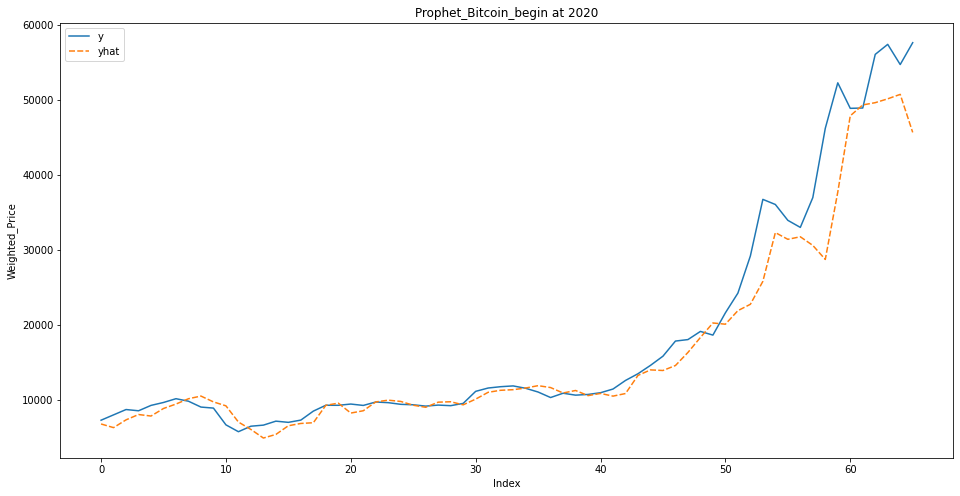

In [57]:
test_data2 = df_valid[['ds','y']]
test_data2 = test_data2.copy()
yhat = forecast2.loc[:,"yhat"].values
test_data2.insert(2,column ="yhat" ,value = yhat)
test_data2 = test_data2.reset_index(drop = True)

plt.figure(figsize=(16, 8))
ax2 = sns.lineplot(data = test_data2)
ax2.set(xlabel = "Index", ylabel = "Weighted_Price",title ='Prophet_Bitcoin_begin at 2020')

[Text(0, 0.5, 'Weighted_Price'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Prophet_Bitcoin after  we adding exogenous_features')]

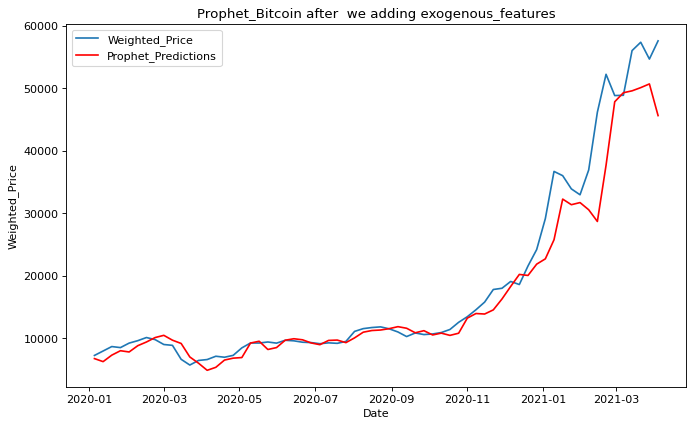

In [58]:
figure(figsize=(10, 6), dpi=80)
ax2 = sns.lineplot(data = test_data2, x= 'ds',y ='y',label ='Weighted_Price')
sns.lineplot(data = test_data2, x= 'ds',y ='yhat',color = 'r',label ='Prophet_Predictions')
ax2.set(xlabel = "Date", ylabel = "Weighted_Price",title ='Prophet_Bitcoin after  we adding exogenous_features')

In [59]:
from sklearn.metrics import mean_absolute_error

prophet_rmse2 = rmse(test_data2['y'], test_data2["yhat"])
prophet_mse2 = prophet_rmse2**2
mean_value2 = test_data2['y'].mean()
diff = round(((prophet_rmse2-prophet_rmse)/prophet_rmse),3)
print("Before:\n"f' RMSE:{prophet_rmse}\n MSE:{prophet_mse}\n Mean:{mean_value}\n'
    "After:\n"f' RMSE:{prophet_rmse2}\n MSE:{prophet_mse2}\n Mean:{mean_value2}\n','\n'
    "Difference of RMSE:"f'{diff}')

Before:
 RMSE:16679.346682838932
 MSE:278200605.76633006
 Mean:18078.522318503947
After:
 RMSE:4019.5652155076923
 MSE:16156904.521719402
 Mean:18078.522318503947
 
Difference of RMSE:-0.759
